# Trading Indicators

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests

## Train Data

In [18]:
data = pd.read_csv("../raw_data/gemini_BTCUSD_1hr.csv")

In [19]:
data.reset_index(inplace=True)
column_names=['Unix Timestamp','Date','Symbol','Open','High','Low','Close','Volume']
data.columns = column_names
data = data.iloc[1:].copy()

#transform to datetime
data['Date'] = pd.to_datetime(data['Date'])

#transform numerics into floats
numerics = ['Open','High','Low','Close','Volume']
for k in numerics:
    data[k] = pd.to_numeric(data[k])
    
#set date to index 
data = data.set_index('Date')

data = data.drop(columns=['Unix Timestamp', 'Symbol'])
data = data.resample("4H").mean()

data.columns=['open','high','low','close','volume']


for x in ['open', 'high', 'low', 'close']:
    data[f'log_{x}'] = data[x].apply(lambda x: np.log(x))
    
    


In [20]:
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close
Date,,,,,,,,,
2015-10-08 12:00:00,163.333333,245.0000,163.1400,244.973333,2.692410,5.095793,5.501258,5.094609,5.501149
2015-10-08 16:00:00,244.540000,244.7250,244.0675,244.310000,3.259453,5.499379,5.500135,5.497445,5.498438
2015-10-08 20:00:00,243.975000,243.9875,243.7675,243.962500,2.659915,5.497066,5.497117,5.496215,5.497015
2015-10-09 00:00:00,243.687500,243.6875,243.6000,243.600000,0.750000,5.495887,5.495887,5.495528,5.495528
2015-10-09 04:00:00,243.600000,243.6000,243.6000,243.600000,0.000000,5.495528,5.495528,5.495528,5.495528
...,...,...,...,...,...,...,...,...,...
2021-08-12 08:00:00,45323.657500,45529.0675,44998.1425,45190.977500,69.830994,10.721584,10.726106,10.714376,10.718653
2021-08-12 12:00:00,44491.795000,44643.4775,44186.6725,44353.090000,114.602881,10.703060,10.706463,10.696178,10.699938
2021-08-12 16:00:00,44198.082500,44414.5750,44034.7175,44248.827500,84.168365,10.696437,10.701323,10.692734,10.697584


## Coingecko 🚒 without volume!!! 👩‍🚒

In [21]:
url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"

response = requests.get(url).json()

In [22]:
df_4h = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
df_4h["Date"] = pd.to_datetime(df_4h["unix_time"], unit='ms')
df_4h = df_4h.drop(columns='unix_time').set_index('Date')

# Get Volume API from Coingecko

In [23]:
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
response = requests.get(url).json()

In [24]:
prices = response['prices']
market_caps = response['market_caps']
total_volumes = response['total_volumes']
#timestamp = unix timestamp
unix_time = [x[0] for x in prices]
prices = [round(x[1],1) for x in prices]
#market_caps = [round(x[1] / 1000000,1) for x in market_caps] #divide by 1mill
#total_volumes = [round(x[1] / 1000000,1) for x in total_volumes] #divide by 1mill
market_caps = [x[1] for x in market_caps]
total_volumes = [x[1] for x in total_volumes]
#create empty dataframe with only time
volume = pd.DataFrame(unix_time,columns=['unix_time'])
#add features
volume['prices'] = pd.DataFrame(prices)
volume['market_caps'] = pd.DataFrame(market_caps)
volume['total_volumes'] = pd.DataFrame(total_volumes)
volume['date'] = pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00")
volume['date'] = pd.to_datetime(volume["date"])
volume = volume.drop(columns='unix_time').set_index('date')

#resample hourly into 4h
volume = volume.resample("4H").mean()

In [25]:
volume.drop(columns=['prices', 'market_caps'], inplace=True)

**clean up the volume to a standard size for prediction**

In [26]:
volume = volume[-180:]
df_4h = df_4h[-181:-1]
full = pd.concat([df_4h, volume], axis=1)
full.columns=['open', 'high', 'low', 'close', 'volume']

for x in ['open', 'high', 'low', 'close']:
    full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

In [27]:
full

,open,high,low,close,volume,log_open,log_high,log_low,log_close
2021-07-25 16:00:00,34093.53,34093.53,34093.53,34093.53,2.042891e+10,10.436863,10.436863,10.436863,10.436863
2021-07-25 20:00:00,34270.91,34453.68,34173.70,34435.26,1.980280e+10,10.442052,10.447371,10.439212,10.446836
2021-07-26 00:00:00,34392.01,34624.04,34392.01,34624.04,2.738916e+10,10.445580,10.452304,10.445580,10.452304
2021-07-26 04:00:00,35527.01,38295.37,35527.01,38253.37,3.566085e+10,10.478049,10.553084,10.478049,10.551987
2021-07-26 08:00:00,38172.55,38714.27,38172.55,38714.27,3.869947e+10,10.549872,10.563964,10.549872,10.563964
...,...,...,...,...,...,...,...,...,...
2021-08-23 20:00:00,49533.17,49533.17,49488.21,49532.43,3.497597e+10,10.810398,10.810398,10.809490,10.810383
2021-08-24 00:00:00,49256.70,49621.94,49256.70,49621.94,3.585965e+10,10.804801,10.812188,10.804801,10.812188
2021-08-24 04:00:00,49518.58,49518.58,49029.38,49180.50,3.754143e+10,10.810103,10.810103,10.800175,10.803252
2021-08-24 08:00:00,49375.99,49676.39,49375.99,49676.39,3.787292e+10,10.807220,10.813285,10.807220,10.813285


# Fear and Greed

In [28]:
url = "https://api.alternative.me/fng/?limit=0&date_format=world"
response = requests.get(url).json()

In [29]:
fag = pd.DataFrame(response['data']).drop(columns='time_until_update')
fag['timestamp'] = pd.to_datetime(fag['timestamp'])
fag = fag.set_index('timestamp').drop(columns='value_classification')

In [30]:
fag

,value
timestamp,
2021-08-24,79
2021-08-23,79
2021-08-22,76
2021-08-21,78
2021-08-20,70
...,...
2018-05-02,11
2018-04-02,24
2018-03-02,40


# Trend Indicator: EMA

## Train

In [31]:
data['ema12'] = data.log_close.ewm(span=12).mean()
data['ema26'] = data.log_close.ewm(span=26).mean()
data['ema20'] = data.log_close.ewm(span=20).mean()
data['ema50'] = data.log_close.ewm(span=50).mean()
data['ema34'] = data.log_close.ewm(span=34).mean()
data['ema55'] = data.log_close.ewm(span=55).mean()

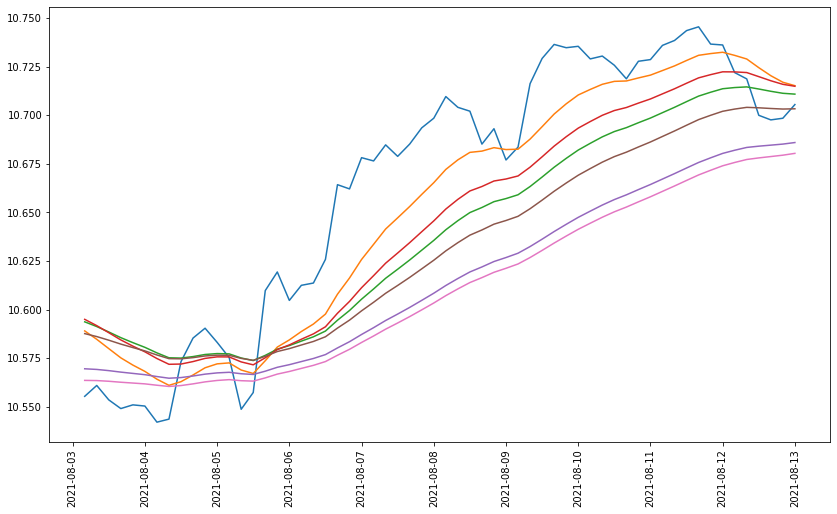

In [32]:
plt.figure(figsize=(14,8))
plt.plot(data[["log_close", "ema12","ema26","ema20","ema50","ema34","ema55"]][-60:])
plt.xticks(rotation=90)
plt.show()

## Coingecko

In [33]:
full['ema12'] = full.log_close.ewm(span=12).mean()
full['ema26'] = full.log_close.ewm(span=26).mean()
full['ema20'] = full.log_close.ewm(span=20).mean()
full['ema50'] = full.log_close.ewm(span=50).mean()
full['ema34'] = full.log_close.ewm(span=34).mean()
full['ema55'] = full.log_close.ewm(span=55).mean()

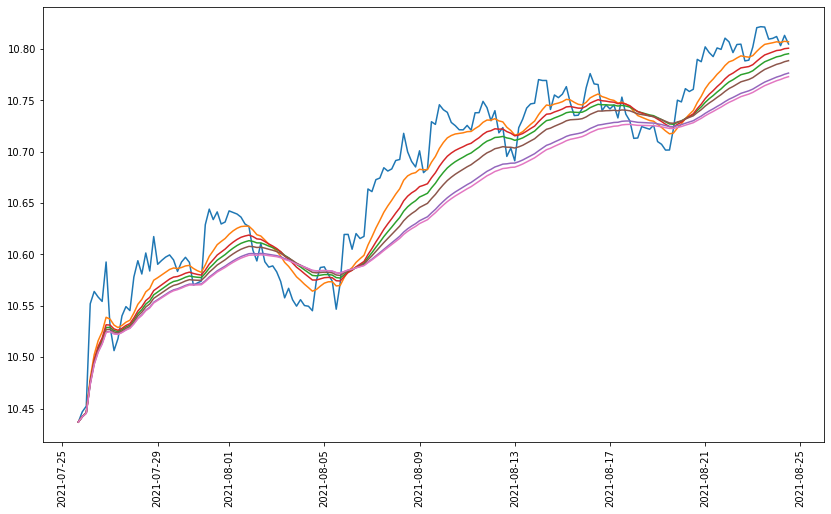

In [34]:
plt.figure(figsize=(14,8))
plt.plot(full[["log_close", "ema12","ema26","ema20","ema50","ema34","ema55"]])
plt.xticks(rotation=90)
plt.show()

# Momentum Indicator: Stoch RSI

## Train Data

A technical indicator based on past prices and volumes of a stock. The RSI has a value between 0 and 100. It is said to be overbought if above 70, and oversold if below 30.

**Transform Stoch RSI into ONE FEATURE?!? Is the model biased towards the number of features**

In [35]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

$$
\text { StochRSI }=\frac{R S I-\min [R S I]}{\max [R S I]-\min [R S I]}
$$

In [36]:
#Stoch RSI = (RSI - Lowest Low RSI) / (Highest High RSI - Lowest Low RSI)
def stoch_rsi(rsi, d_window, k_window, window):
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D    

In [37]:
data['rsi'] = computeRSI(data['log_close'], 14)
data['K'], data['D'] = stoch_rsi(data['rsi'], 3, 3, 14)

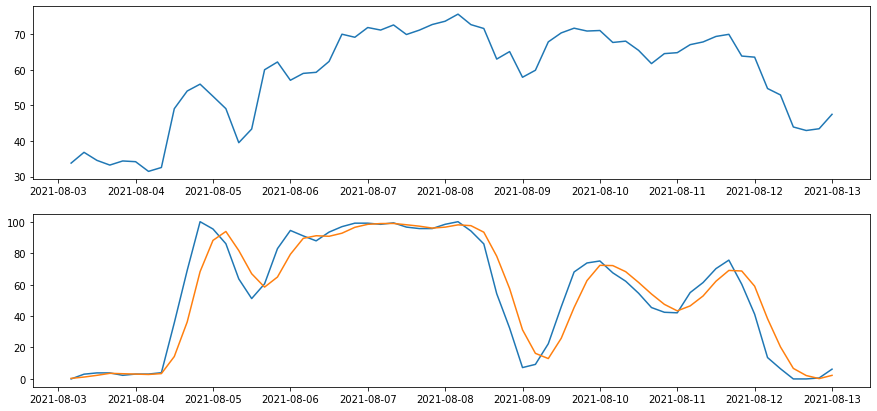

In [38]:
fig, axs = plt.subplots(2,1, figsize=(15,7))
axs[0].plot(data.rsi[-60:])
axs[1].plot(data[["K","D"]][-60:])
plt.show()

## livedata

In [39]:
full['rsi'] = computeRSI(full['log_close'], 14)
full['K'], full['D'] = stoch_rsi(full['rsi'], 3, 3, 14)

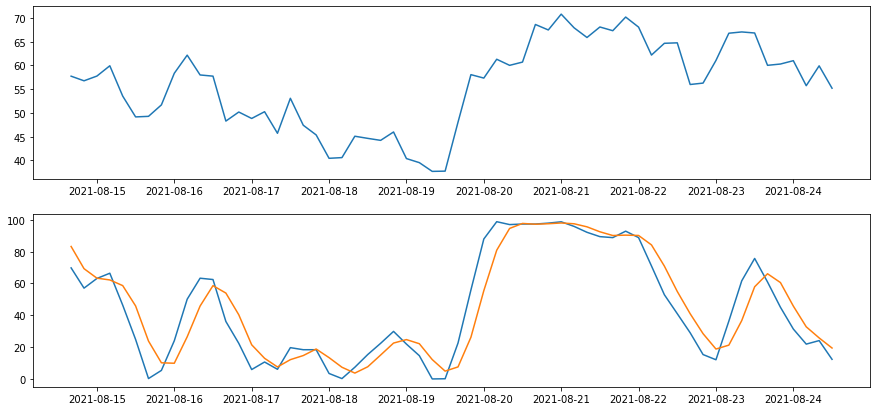

In [40]:
fig, axs = plt.subplots(2,1, figsize=(15,7))
axs[0].plot(full.rsi[-60:])
axs[1].plot(full[["K","D"]][-60:])
plt.show()

# Volatility Indicator: Bollinger Bands

https://medium.com/codex/how-to-calculate-bollinger-bands-of-a-stock-with-python-f9f7d1184fc3

## Train Data

In [41]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()


def get_bollinger_bands(prices, rate=20):
    sma = get_sma(prices, rate) # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down

In [42]:
data['sma'] = get_sma(data['log_close'], 20) # Get 20 day SMA
data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(data['log_close'])

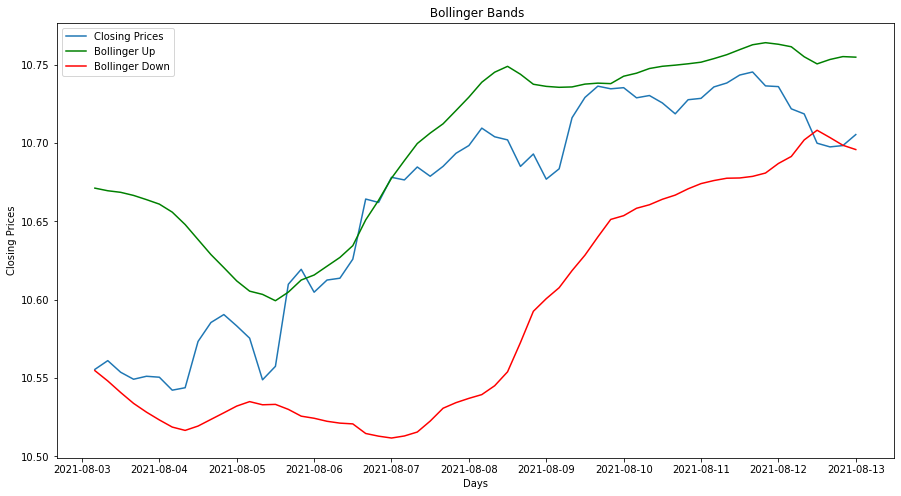

In [43]:
plt.figure(figsize=(15,8))
plt.title(' Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(data['log_close'][-60:], label='Closing Prices')
plt.plot(data['bollinger_up'][-60:], label='Bollinger Up', c='g')
plt.plot(data['bollinger_down'][-60:], label='Bollinger Down', c='r')
plt.legend()
plt.show()

## Coingecko

In [44]:
full['sma'] = get_sma(full['log_close'], 20) # Get 20 day SMA
full['bollinger_up'], full['bollinger_down'] = get_bollinger_bands(full['log_close'])

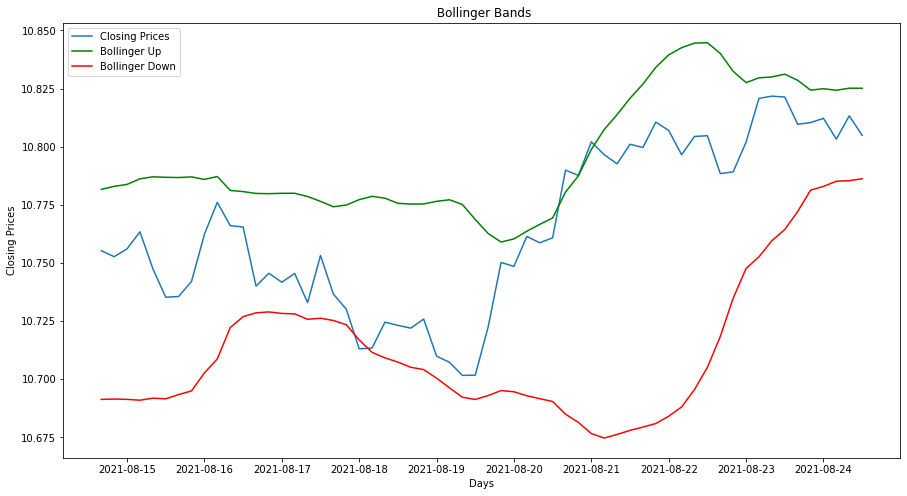

In [45]:
plt.figure(figsize=(15,8))
plt.title(' Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(full['log_close'][-60:], label='Closing Prices')
plt.plot(full['bollinger_up'][-60:], label='Bollinger Up', c='g')
plt.plot(full['bollinger_down'][-60:], label='Bollinger Down', c='r')
plt.legend()
plt.show()

# Volume Indicator: Volume Rate of Change

In [46]:
data['vol_roc'] = data.volume.pct_change()

In [47]:
full['vol_roc'] = full.volume.pct_change()

# final df

In [48]:
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-08 12:00:00,163.333333,245.0000,163.1400,244.973333,2.692410,5.095793,5.501258,5.094609,5.501149,5.501149,...,5.501149,5.501149,5.501149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-08 16:00:00,244.540000,244.7250,244.0675,244.310000,3.259453,5.499379,5.500135,5.497445,5.498438,5.499681,...,5.499767,5.499754,5.499769,NaN,NaN,NaN,NaN,NaN,NaN,0.210608
2015-10-08 20:00:00,243.975000,243.9875,243.7675,243.962500,2.659915,5.497066,5.497117,5.496215,5.497015,5.498640,...,5.498812,5.498786,5.498817,NaN,NaN,NaN,NaN,NaN,NaN,-0.183938
2015-10-09 00:00:00,243.687500,243.6875,243.6000,243.600000,0.750000,5.495887,5.495887,5.495528,5.495528,5.497658,...,5.497941,5.497898,5.497949,NaN,NaN,NaN,NaN,NaN,NaN,-0.718036
2015-10-09 04:00:00,243.600000,243.6000,243.6000,243.600000,0.000000,5.495528,5.495528,5.495528,5.495528,5.497079,...,5.497419,5.497367,5.497429,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-12 08:00:00,45323.657500,45529.0675,44998.1425,45190.977500,69.830994,10.721584,10.726106,10.714376,10.718653,10.728882,...,10.683421,10.704030,10.677226,52.964317,6.492348,20.410931,10.728592,10.755154,10.702030,-0.222081
2021-08-12 12:00:00,44491.795000,44643.4775,44186.6725,44353.090000,114.602881,10.703060,10.706463,10.696178,10.699938,10.724429,...,10.684069,10.703796,10.678037,43.949610,0.000000,6.694552,10.729410,10.750604,10.708215,0.641146
2021-08-12 16:00:00,44198.082500,44414.5750,44034.7175,44248.827500,84.168365,10.696437,10.701323,10.692734,10.697584,10.720299,...,10.684599,10.703441,10.678735,42.959383,0.000000,2.164116,10.728478,10.753421,10.703536,-0.265565


In [49]:
full

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc
2021-07-25 16:00:00,34093.53,34093.53,34093.53,34093.53,2.042891e+10,10.436863,10.436863,10.436863,10.436863,10.436863,...,10.436863,10.436863,10.436863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-25 20:00:00,34270.91,34453.68,34173.70,34435.26,1.980280e+10,10.442052,10.447371,10.439212,10.446836,10.442265,...,10.441949,10.441996,10.441940,NaN,NaN,NaN,NaN,NaN,NaN,-0.030648
2021-07-26 00:00:00,34392.01,34624.04,34392.01,34624.04,2.738916e+10,10.445580,10.452304,10.445580,10.452304,10.446183,...,10.445540,10.445636,10.445521,NaN,NaN,NaN,NaN,NaN,NaN,0.383095
2021-07-26 04:00:00,35527.01,38295.37,35527.01,38253.37,3.566085e+10,10.478049,10.553084,10.478049,10.551987,10.479581,...,10.473769,10.474614,10.473607,NaN,NaN,NaN,NaN,NaN,NaN,0.302006
2021-07-26 08:00:00,38172.55,38714.27,38172.55,38714.27,3.869947e+10,10.549872,10.563964,10.549872,10.563964,10.502508,...,10.493279,10.494646,10.493016,NaN,NaN,NaN,NaN,NaN,NaN,0.085209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-23 20:00:00,49533.17,49533.17,49488.21,49532.43,3.497597e+10,10.810398,10.810398,10.809490,10.810383,10.806096,...,10.771066,10.783447,10.767563,60.302663,45.047772,60.560964,10.802817,10.824339,10.781295,0.010049
2021-08-24 00:00:00,49256.70,49621.94,49256.70,49621.94,3.585965e+10,10.804801,10.812188,10.804801,10.812188,10.807033,...,10.772680,10.785089,10.769159,61.007508,31.361309,45.771962,10.803930,10.824942,10.782918,0.025265
2021-08-24 04:00:00,49518.58,49518.58,49029.38,49180.50,3.754143e+10,10.810103,10.810103,10.800175,10.803252,10.806452,...,10.773880,10.786127,10.770378,55.733059,21.884217,32.764433,10.804711,10.824285,10.785137,0.046899
2021-08-24 08:00:00,49375.99,49676.39,49375.99,49676.39,3.787292e+10,10.807220,10.813285,10.807220,10.813285,10.807503,...,10.775426,10.787679,10.771913,59.922484,24.089869,25.778465,10.805270,10.825166,10.785373,0.008830


In [50]:
full.tail(144)

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc
2021-07-31 16:00:00,41616.38,41620.64,41343.37,41343.37,3.437979e+10,10.636249,10.636351,10.629667,10.629667,10.612624,...,10.586390,10.592303,10.585151,62.257917,75.716062,83.383725,10.601955,10.647658,10.556251,-0.017813
2021-07-31 20:00:00,41581.64,41581.64,41192.33,41423.15,3.174260e+10,10.635414,10.635414,10.626007,10.631595,10.615548,...,10.588659,10.594817,10.587366,62.663801,70.948122,78.379658,10.603463,10.651046,10.555880,-0.076708
2021-08-01 00:00:00,41319.56,41906.23,41319.56,41874.18,2.711204e+10,10.629091,10.643190,10.629091,10.642425,10.619689,...,10.591328,10.597842,10.589961,64.944436,68.061992,71.575392,10.606389,10.656059,10.556720,-0.145878
2021-08-01 04:00:00,41699.54,41809.25,41699.54,41809.25,2.686583e+10,10.638245,10.640873,10.638245,10.640873,10.622952,...,10.593762,10.600559,10.592333,64.337972,72.325264,70.445126,10.607562,10.659388,10.555735,-0.009081
2021-08-01 08:00:00,42628.50,42628.50,41746.57,41746.57,2.585866e+10,10.660278,10.660278,10.639373,10.639373,10.625481,...,10.595981,10.602996,10.594501,63.718446,74.486862,71.624706,10.610010,10.663037,10.556983,-0.037489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-23 20:00:00,49533.17,49533.17,49488.21,49532.43,3.497597e+10,10.810398,10.810398,10.809490,10.810383,10.806096,...,10.771066,10.783447,10.767563,60.302663,45.047772,60.560964,10.802817,10.824339,10.781295,0.010049
2021-08-24 00:00:00,49256.70,49621.94,49256.70,49621.94,3.585965e+10,10.804801,10.812188,10.804801,10.812188,10.807033,...,10.772680,10.785089,10.769159,61.007508,31.361309,45.771962,10.803930,10.824942,10.782918,0.025265
2021-08-24 04:00:00,49518.58,49518.58,49029.38,49180.50,3.754143e+10,10.810103,10.810103,10.800175,10.803252,10.806452,...,10.773880,10.786127,10.770378,55.733059,21.884217,32.764433,10.804711,10.824285,10.785137,0.046899
2021-08-24 08:00:00,49375.99,49676.39,49375.99,49676.39,3.787292e+10,10.807220,10.813285,10.807220,10.813285,10.807503,...,10.775426,10.787679,10.771913,59.922484,24.089869,25.778465,10.805270,10.825166,10.785373,0.008830


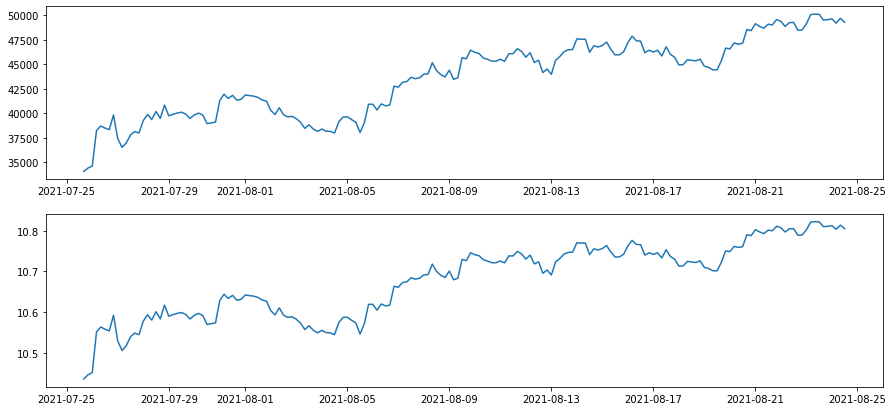

In [51]:
fig, axs = plt.subplots(2,1, figsize=(15,7))
axs[0].plot(full.close)
axs[1].plot(full.log_close)
plt.show()

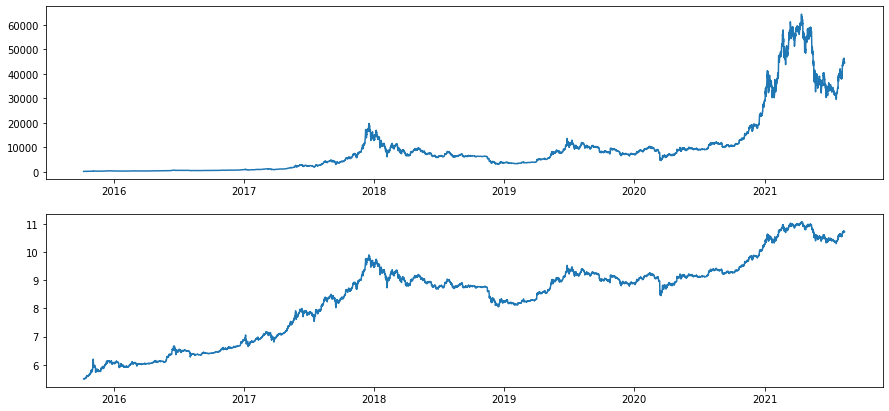

In [52]:
fig, axs = plt.subplots(2,1, figsize=(15,7))
axs[0].plot(data.close)
axs[1].plot(data.log_close)
plt.show()

In [53]:
df = data[['close', 'log_close']].copy()

In [54]:
df

,close,log_close
Date,,
2015-10-08 12:00:00,244.973333,5.501149
2015-10-08 16:00:00,244.310000,5.498438
2015-10-08 20:00:00,243.962500,5.497015
2015-10-09 00:00:00,243.600000,5.495528
2015-10-09 04:00:00,243.600000,5.495528
...,...,...
2021-08-12 08:00:00,45190.977500,10.718653
2021-08-12 12:00:00,44353.090000,10.699938
2021-08-12 16:00:00,44248.827500,10.697584


In [55]:
df['exp_close'] = df['log_close'].apply(lambda x: np.exp(x))

In [56]:
df

,close,log_close,exp_close
Date,,,
2015-10-08 12:00:00,244.973333,5.501149,244.973333
2015-10-08 16:00:00,244.310000,5.498438,244.310000
2015-10-08 20:00:00,243.962500,5.497015,243.962500
2015-10-09 00:00:00,243.600000,5.495528,243.600000
2015-10-09 04:00:00,243.600000,5.495528,243.600000
...,...,...,...
2021-08-12 08:00:00,45190.977500,10.718653,45190.977500
2021-08-12 12:00:00,44353.090000,10.699938,44353.090000
2021-08-12 16:00:00,44248.827500,10.697584,44248.827500
